Se importan las librerías de interés

In [4]:
#Importar las librerías de uso
import pandas as pd
import numpy as np
from scipy import optimize
import numpy_financial as npf
import itertools 

Creamos funciones de interés:
- Construir un dataframe con nuestras variables de interés en base a dos documentos
- Aplicar el f-chart method

Función para aplicar el f-chart method

In [5]:
def f_chart_method(n_1,n_2,n_3,U, t_mensual, interest_rate, cos_sc, cos_V, A, sol_ratio, CO2_ratio):
        
    #Cálculo de las variables de los colectores solares
    F_R_t= n_1*n_2*n_3
    F_R_U_l= n_3*U

    #Se crean las variables de interés
    f_value=[]
    aporte_solar_MJ=[]
    rendimiento=[]
    backup_SOL=[]
    CO2_kg=[]
    number_collector=[]
    tir=[]
    inversion= []
    VAN=[]
    payback=[]
    
    

    #Cálculo para cada una de las áreas 

    for N in range (1,21):
        #Calculations
        sc= A*N   #Área predimensionada (m2)
        V= A*75   #Volumen predimensionado (l)
        invertion= sc*cos_sc+V*cos_V
        t_mensual["X"]=F_R_U_l*3600*(100-t_mensual["Temp_outdoor"])*t_mensual["Sun_hours"]*t_mensual["Days_month"]*sc/(t_mensual["Total_demand_MJ"]*1000000)
        t_mensual["Y"]= F_R_t*t_mensual["Rad_enegy_MJ"]*1000000*sc/(t_mensual["Total_demand_MJ"]*1000000)
        t_mensual["f_value"]=1.020*t_mensual["Y"]-0.065*t_mensual["X"]-0.245*t_mensual["Y"].pow(2)+ 0.0018*t_mensual["X"]+0.0215*t_mensual["Y"].pow(3)
        t_mensual["aporte_solar_MJ"]= t_mensual["f_value"]*t_mensual["Total_demand_MJ"]
        t_mensual["rendimiento"]= t_mensual["aporte_solar_MJ"]/(t_mensual["Rad_enegy_MJ"]*sc)
        t_mensual["backup_cost_SOL"]= (t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*sol_ratio*0.2777
        t_mensual["CO2_kg"]= (t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*CO2_ratio
        t_mensual["Ahorro"]=(t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*sol_ratio*0.277
        
        
        #Important parameters results
        f_value.append(t_mensual["aporte_solar_MJ"].sum()/t_mensual["Total_demand_MJ"].sum())
        rendimiento.append(t_mensual["rendimiento"].mean())
        aporte_solar_MJ.append(t_mensual.aporte_solar_MJ.sum())
        number_collector.append(N)
        backup_SOL.append(t_mensual["backup_cost_SOL"].sum())
        CO2_kg.append(t_mensual["CO2_kg"].sum())
        inversion.append(invertion)
        

        #Calculations of the cash flows
        
        income=[]
        outcome=[]
        years=[]
        N_col=[]
        
        for a in range (1,6):
            outcome.append(t_mensual["backup_cost_SOL"].sum())
            income.append((t_mensual["Total_demand_MJ"]*0.277*sol_ratio).sum())
            years.append(a)
            N_col.append(N)
    
        balance= pd.DataFrame({'income':income,'outcome':outcome, "years":years, "N_colectors":N_col})
        balance["cash_flow"]= balance["income"]-balance["outcome"]
        
        cash= [invertion*-1]
        cash.append(list(balance["cash_flow"]))
        flat_list = itertools.chain(*cash)
        flat_list=[]
            
        def flatten_list (data):
        
            for element in data:
                if type(element) == list:
                    flatten_list(element)
                else:
                    flat_list.append(element)
                
        flatten_list(cash)
        
        VAN_i= npf.npv(interest_rate,flat_list)
        VAN.append(VAN_i)
        
        tir_i= npf.irr(flat_list)
        tir.append(tir_i)
        
        
        cumulative_cash_flows = 0
        payback_period= 0
        
        while cumulative_cash_flows < invertion:
            cumulative_cash_flows += flat_list [payback_period]
            payback_period+=1
            
            if payback_period== len(flat_list):
                break
        payback.append(payback_period)

    #Se guardan los datos en resultados técnicos
    df_technical_results=pd.DataFrame(list(zip(number_collector,rendimiento, f_value,aporte_solar_MJ, backup_SOL, CO2_kg,inversion, VAN, tir, payback)), columns=["number_collector","rendimiento","f_value","aporte_solar_MJ", "backup_SOL", "CO2_kg", "inversion", "VAN", "TIR", "payback"])

    
    return (df_technical_results)

Función para construir dataframe mensual

In [6]:
def constr_df(case_thermal, t_mensual):
    #Arreglamos los tipos de datos
    #Set the date column as index 
    case_thermal["Date/Time"]= pd.to_datetime(case_thermal["Date/Time"] )
    case_thermal["Zone Heating"]= pd.to_numeric(case_thermal["Zone Heating"])
    case_thermal["DHW (Electricity)"]= pd.to_numeric(case_thermal["DHW (Electricity)"])
    case_thermal["Direct Normal Solar"]= pd.to_numeric(case_thermal["Direct Normal Solar"])
    case_thermal['Diffuse Horizontal Solar']= pd.to_numeric(case_thermal['Diffuse Horizontal Solar'])
    case_thermal['Outside Dry-Bulb Temperature']= pd.to_numeric(case_thermal['Outside Dry-Bulb Temperature'])

    case_thermal= case_thermal.set_index("Date/Time")

    #Reorganizamos los datos de forma mensual (promedio de temperatura)
    df_monthly_temp= case_thermal[["Outside Dry-Bulb Temperature"]].resample("M").mean()

    #Reorganizamos los datos de forma mensual (calefacción, y agua caliente)
    df_monthly_sum= case_thermal[["Zone Heating", "DHW (Electricity)", "Direct Normal Solar", 'Diffuse Horizontal Solar']].resample("M").sum()

    df_monthly_sum["Total_demand_kwh"]= df_monthly_sum["Zone Heating"]+ df_monthly_sum["DHW (Electricity)"]

    df_monthly_sum["Rad_enegy_MJ"] = (df_monthly_sum['Diffuse Horizontal Solar'] + df_monthly_sum['Direct Normal Solar'])*3.6*0.22

    #Calculamos la demanda total de energía de calefacción y agua caliente sanitaria
    df_monthly_sum["Total_demand_MJ"] = df_monthly_sum["Total_demand_kwh"]*3.6


    #Se integra la columna de demanda total calculada de la simulación
    t_mensual["Total_demand_MJ"]= list(df_monthly_sum["Total_demand_MJ"])

    #Se integra la columna de radiación mensual calculada de la simulación
    t_mensual["Rad_enegy_MJ"]= list(df_monthly_sum["Rad_enegy_MJ"])

    #Se integra la temperatura de outdoor
    t_mensual["Temp_outdoor"] = list(df_monthly_temp["Outside Dry-Bulb Temperature"])
    
    return (t_mensual)

Función para aplicación del f-chart para un sólo área de colector

In [7]:
def collector_size(N,A,t_mensual, cos_sc, cos_V, n_1,n_2,n_3, CO2_ratio, sol_ratio):
    sc= A*N   #Área predimensionada (m2)
    V= A*75   #Volumen predimensionado (l)
    F_R_t= n_1*n_2*n_3
    F_R_U_l= n_3*U
    invertion= sc*cos_sc+V*cos_V
    t_mensual["X"]=F_R_U_l*3600*(100-t_mensual["Temp_outdoor"])*t_mensual["Sun_hours"]*t_mensual["Days_month"]*sc/(t_mensual["Total_demand_MJ"]*1000000)
    t_mensual["Y"]= n_1*n_3*n_2*t_mensual["Rad_enegy_MJ"]*1000000*sc/(t_mensual["Total_demand_MJ"]*1000000)
    t_mensual["f_value"]=1.020*t_mensual["Y"]-0.065*t_mensual["X"]-0.245*t_mensual["Y"].pow(2)+ 0.0018*t_mensual["X"]+0.0215*t_mensual["Y"].pow(3)
    t_mensual["aporte_solar_MJ"]= t_mensual["f_value"]*t_mensual["Total_demand_MJ"]
    t_mensual["rendimiento"]= t_mensual["aporte_solar_MJ"]/(t_mensual["Rad_enegy_MJ"]*sc)
    t_mensual["backup_cost_SOL"]= (t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*sol_ratio*0.2777
    t_mensual["CO2_kg"]= (t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*CO2_ratio
    t_mensual["Ahorro"]=(t_mensual["Total_demand_MJ"]-t_mensual["aporte_solar_MJ"])*sol_ratio*0.277
    
    return(t_mensual)

Leemos los datos de interés de los diversos documentos de entrada

In [16]:
#Leemos los datos de la simulación
case_thermal= pd.read_csv("DesignBuilder\Casos demanda\Results demand\case 3 - thermal demand - hourly.csv", encoding= "latin-1", sep=";")
case_thermal=case_thermal.drop([0], axis=0)

#Leer los datos de horas de sol, radiación global mensual, días, temperatura de agua de red
t_mensual= pd.read_csv("input_month.csv", sep=";")

In [9]:
t_mensual

,Month,Month_numb,Days_month,Temp_red,Rad_enegy_MJ,Temp_outdoor,Sun_hours,Thermal_demand_MJ
0,Enero,1,31,12.53,7.8,9,8,4830.587455
1,Febrero,2,28,12.58,10.8,10,7,4358.515598
2,Marzo,3,31,12.55,15.2,13,9,4828.552238
3,Abril,4,30,12.35,18.5,16,5,4692.488136
4,Mayo,5,31,11.37,21.9,18,8,4948.630038
5,Junio,6,30,10.35,24.8,24,7,4889.444616
6,Julio,7,31,9.93,26.7,27,8,5095.165659
7,Agosto,8,31,10.96,23.6,27,9,4990.351986
8,Setiembre,9,30,12.09,18.8,24,9,4718.092478
9,Octubre,10,31,13.21,12.9,18,10,4761.390078


Ponemos los datos de entrada

In [17]:
#Datos de los captadores

A=2.5   #Área de un colector solar

#Datos del colector
n_1= 0.696 #Eficiencia óptica del colector
n_2= 0.94  #Modificador del ángulo de incidencia
n_3= 0.95 #Factor de corrección del conjunto intercambiador
U= 4.821   #Coeficiente de pérdidas lineales


#Datos de producción de CO2
CO2_ratio= 0.41    #CO2equi/kWh

#Datos de costos
sol_ratio= 0.77   #soles/kWh
cos_sc= 320          #soles/m2
cos_V= 0.72          #soles/kg


interest_rate = 0.1  # The default guess value


#Cálculo de las variables de los colectores solares
F_R_t= n_1*n_2*n_3
F_R_U_l= n_3*U

Aplicamos las funciones

In [18]:
N= 1
t_mensual= constr_df(case_thermal, t_mensual)
df_technical_results = f_chart_method(n_1,n_2,n_3,U, t_mensual, interest_rate, cos_sc, cos_V, A, sol_ratio, CO2_ratio)
size_monthly= collector_size(N,A,t_mensual, cos_sc, cos_V, n_1,n_2,n_3, CO2_ratio, sol_ratio)

C:\Users\mayte\AppData\Local\Temp\ipykernel_24324\3713482730.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  case_thermal["Date/Time"]= pd.to_datetime(case_thermal["Date/Time"] )


KeyError: 'Zone Heating'

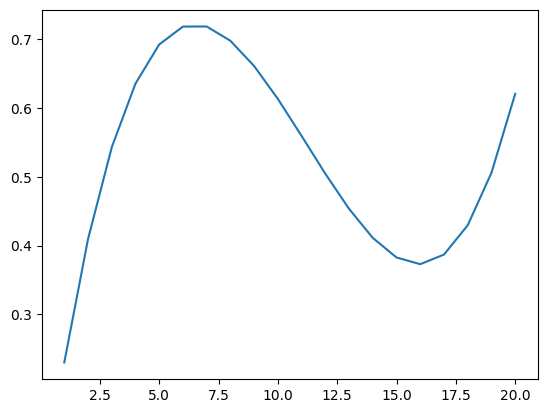

In [55]:
import matplotlib.pyplot as plt

plt.plot("number_collector", "f_value", data= df_technical_results )

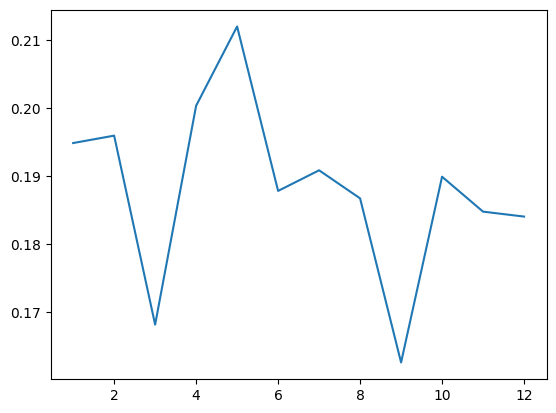

In [40]:
plt.plot("Month_numb", "f_value", data= size_monthly )


Se guardan los datos de los resultados técnicos en un archivo csv

In [ ]:
#Se guardan los datos en resultados técnicos
df_technical_results.to_csv("CleanData/tech_results_df.csv")


Leemos los datos de la simulación, y el consumo por backup para un área pequeña de colector solar (1.9 m2)

In [28]:
result_backup= pd.read_csv("DesignBuilder\Resultados HVAC\Solar\Small Collector.csv", sep= ";", skiprows=[0,1])
result_backup=result_backup.drop([0], axis=0)

result_backup["Date/Time"]= pd.to_datetime(result_backup["Date/Time"] )
result_backup["[1] Water Heater Electricity Rate (W)"]= pd.to_numeric(result_backup["[1] Water Heater Electricity Rate (W)"] )

result_backup= result_backup.set_index("Date/Time")
result_backup_month= result_backup[["[1] Water Heater Electricity Rate (W)"]].resample("M").sum()*10**(-3)

In [29]:
result_backup_month

,[1] Water Heater Electricity Rate (W)
Date/Time,
2002-01-31,27.807739
2002-02-28,89.253738
2002-03-31,71.811296
2002-04-30,89.117341
2002-05-31,73.547344
2002-06-30,108.164954
2002-07-31,107.075556
2002-08-31,83.690296
2002-09-30,87.752518


In [30]:
df_analysis_solar= pd.DataFrame()
df_analysis_solar["backup_kWh"]= result_backup_month["[1] Water Heater Electricity Rate (W)"]
df_analysis_solar["demand_kwh"]= df_monthly_sum["Total_demand_kwh"]
df_analysis_solar["solar_fraction"]= (df_analysis_solar["demand_kwh"]-df_analysis_solar["backup_kWh"])/df_analysis_solar["demand_kwh"]

In [31]:
df_analysis_solar

,backup_kWh,demand_kwh,solar_fraction
Date/Time,,,
2002-01-31,27.807739,47.750187,0.417641
2002-02-28,89.253738,89.983208,0.008107
2002-03-31,71.811296,70.158062,-0.023564
2002-04-30,89.117341,94.257867,0.054537
2002-05-31,73.547344,92.612938,0.205863
2002-06-30,108.164954,149.234453,0.275201
2002-07-31,107.075556,147.403698,0.273590
2002-08-31,83.690296,104.718650,0.200808
2002-09-30,87.752518,101.954419,0.139297


Leemos los datos para un colector solar más grande (4.41 m2)

In [32]:
result_backup= pd.read_csv("DesignBuilder\Resultados HVAC\Solar\Big Collector.csv", sep= ";", skiprows=[0,1])
result_backup=result_backup.drop([0], axis=0)

result_backup["Date/Time"]= pd.to_datetime(result_backup["Date/Time"] )
result_backup["[1] Water Heater Electricity Rate (W)"]= pd.to_numeric(result_backup["[1] Water Heater Electricity Rate (W)"] )

result_backup= result_backup.set_index("Date/Time")
result_backup_month= result_backup[["[1] Water Heater Electricity Rate (W)"]].resample("M").sum()*10**(-3)

In [33]:
result_backup_month

,[1] Water Heater Electricity Rate (W)
Date/Time,
2002-01-31,6.169514
2002-02-28,8.011572
2002-03-31,2.383842
2002-04-30,7.216734
2002-05-31,7.833807
2002-06-30,59.822107
2002-07-31,62.843119
2002-08-31,15.736156
2002-09-30,22.581557


Hacemos el análisis de rendimiento y fracción solar

In [46]:
A=4.41
df_analysis_solar= pd.DataFrame()
df_analysis_solar["backup_kWh"]= result_backup_month["[1] Water Heater Electricity Rate (W)"]
df_analysis_solar["demand_kwh"]= df_monthly_sum["Total_demand_kwh"]
df_analysis_solar["input_solar_kwh"]= (df_monthly_sum['Diffuse Horizontal Solar'] + df_monthly_sum['Direct Normal Solar'])*A*0.22
df_analysis_solar["solar_fraction"]= (df_analysis_solar["demand_kwh"]-df_analysis_solar["backup_kWh"])/df_analysis_solar["demand_kwh"]
df_analysis_solar["rendimiento"]= (df_analysis_solar["demand_kwh"]-df_analysis_solar["backup_kWh"])/df_analysis_solar["input_solar_kwh"]

In [47]:
df_analysis_solar

,backup_kWh,demand_kwh,input_solar_kwh,solar_fraction,rendimiento
Date/Time,,,,,
2002-01-31,6.169514,47.750187,182.531313,0.870796,0.227800
2002-02-28,8.011572,89.983208,160.088200,0.910966,0.512040
2002-03-31,2.383842,70.158062,168.583737,0.966022,0.402021
2002-04-30,7.216734,94.257867,163.015323,0.923436,0.533944
2002-05-31,7.833807,92.612938,196.480548,0.915413,0.431489
2002-06-30,59.822107,149.234453,179.322454,0.599140,0.498612
2002-07-31,62.843119,147.403698,189.253528,0.573667,0.446811
2002-08-31,15.736156,104.718650,184.219024,0.849729,0.483026
2002-09-30,22.581557,101.954419,159.785789,0.778513,0.496745


Verificaré que la demanda de energía sea igual a la tabla anerior en KWh

In [26]:
result_demand= pd.read_csv("DesignBuilder/Resultados HVAC/Solar/No Collector.csv", sep= ";", skiprows=[0,1])
result_demand=result_demand.drop([0], axis=0)


result_demand["Date/Time"]= pd.to_datetime(result_demand["Date/Time"] )
result_demand["[1] DistrictHeating:Facility (W)"]= pd.to_numeric(result_demand["[1] DistrictHeating:Facility (W)"] )

result_demand= result_demand.set_index("Date/Time")
result_demand_month= result_demand[["[1] DistrictHeating:Facility (W)"]].resample("M").sum()*10**(-3)

In [27]:
result_demand_month

,[1] DistrictHeating:Facility (W)
Date/Time,
2002-01-31,47.685470
2002-02-28,90.478015
2002-03-31,70.038568
2002-04-30,93.439388
2002-05-31,92.505276
2002-06-30,149.425425
2002-07-31,147.384119
2002-08-31,104.824751
2002-09-30,101.611335


In [23]:
result_demand

,[1] DistrictHeating:Facility (W)
Date/Time,
2002-01-01 01:00:00,66.489710
2002-01-01 02:00:00,66.489710
2002-01-01 03:00:00,66.489710
2002-01-01 04:00:00,66.489710
2002-01-01 05:00:00,66.489710
...,...
2002-12-31 20:00:00,0.000000
2002-12-31 21:00:00,66.489710
2002-12-31 22:00:00,66.489710
